<a href="https://colab.research.google.com/github/ushakiet01/FMML_PROJECTS_AND_ASSIGNMENTS/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 08:45:56--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.55, 18.239.225.61, 18.239.225.41, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   110MB/s    in 0.4s    

2024-05-12 08:45:57 (110 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


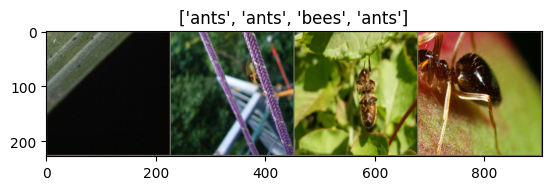

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.9MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5175 Acc: 0.7090

Epoch 1/4
----------
Loss: 0.4031 Acc: 0.8320

Epoch 2/4
----------
Loss: 0.5700 Acc: 0.7787

Epoch 3/4
----------
Loss: 0.5847 Acc: 0.8156

Epoch 4/4
----------


In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


3.
Yes, you can still achieve good performance using a pretrained ResNet model even if it was originally trained on a dataset significantly different from a specific task like classifying ants versus bees. The effectiveness of using such a pretrained model hinges on several fundamental aspects of deep learning and transfer learning:

Generic Feature Extraction: Deep convolutional neural networks like ResNet are known for their ability to learn hierarchical features that are applicable to a wide range of image recognition tasks. Early layers of these networks typically capture universal features such as edges, textures, and colors, which are relevant across different image datasets. These features are often sufficient to achieve decent performance on new, albeit different, datasets after some fine-tuning.

Fine-Tuning: To adapt a pretrained model to a new task, you typically employ a technique known as fine-tuning. Here, you start with the weights from the pretrained model and continue training (i.e., fine-tuning) on the new dataset. During fine-tuning, the model adjusts its weights, especially in the deeper layers, to better suit the specific characteristics of the new data. This can significantly boost performance even if the new dataset is quite different from the original training dataset.

Adaptability of Deep Learning Models: Deep learning models, especially those with architectures like ResNet, are quite adaptable. Their depth and capacity allow them to model complex patterns and nuances of new datasets effectively, provided they are given enough training examples during the fine-tuning phase.

Size and Diversity of the Pretraining Dataset: If the pretrained model was trained on a large and diverse dataset (like ImageNet, which contains millions of images and thousands of classes), it's more likely that the model has developed a robust and generalizable set of features that can be effective across many different tasks, including those that are significantly different from the original training data.

Amount of Fine-Tuning Needed: The extent to which fine-tuning is needed can depend on how different the new dataset is from the original one. For a task like distinguishing between ants and bees, which is still within the broader scope of natural image recognition, substantial benefits can be gained from the pretrained features. However, adjustments primarily in the last few layers might be necessary to tailor the network to the specifics of the task.

In conclusion, using a pretrained ResNet model is generally beneficial even when the new task involves a dataset significantly different from the one used for pretraining. The universal applicability of the learned features, combined with the flexibility provided by fine-tuning, typically results in a strong performance boost compared to training a model from scratch. However, the extent of fine-tuning and the specific layers you choose to adjust can vary depending on how different the new dataset is from the original training set.

2.When training a ResNet model from scratch, without using the pretrained weights (i.e., setting pretrained=False), several key differences in performance, training time, and resource utilization can be expected compared to using a pretrained model. Here’s a detailed breakdown of what typically happens:

Longer Training Time: Pretrained models come with weights that have already been optimized on a large and diverse dataset, usually ImageNet. Starting from these learned weights significantly speeds up the convergence of the model during training because it doesn't have to learn features from scratch. Without these initial weights, the model needs more epochs to learn effective representations, thus extending the total training time.

Increased Data Requirements: Pretrained models can perform well even on smaller datasets because they leverage learned features applicable across a wide range of visual tasks. Without these pretrained weights, the model often requires a much larger dataset to achieve similar performance. This is because it must learn all the necessary features on its own, starting from randomly initialized weights.

Lower Initial Performance: Initially, and potentially even after extended training, models trained from scratch typically exhibit lower performance compared to their pretrained counterparts. This is particularly noticeable in complex tasks or tasks where the dataset is relatively small or lacks variability. The pretrained model's advantage comes from having been exposed to millions of images and thousands of categories, capturing a broad spectrum of features.

Potential for Overfitting: Training a model from scratch on a small dataset can lead to overfitting, where the model learns to perform very well on the training data but poorly generalizes to new, unseen data. Pretrained models, by virtue of already understanding general features, are less prone to this unless the fine-tuning process is mishandled.

Need for Hyperparameter Tuning: Without pretrained weights, the sensitivity to the choice of hyperparameters (like learning rate, batch size, number of layers to train vs. freeze) can increase. Finding the right set of hyperparameters without the guidance provided by pretrained weights can be more challenging and may require extensive experimentation.

Potential for Different Feature Learning: When trained from scratch, the model might end up learning a different set of features compared to what it would learn with pretrained initialization. This can be both a negative and a positive — negative if it misses learning universally useful features, positive if it adapts better to the specific nuances of the new dataset.

If you choose to train a ResNet model from scratch, it’s important to adjust your expectations and strategies:

Consider increasing your dataset size or artificially augmenting your existing dataset.
Be prepared to spend more time on hyperparameter tuning.
Implement regularization techniques to mitigate overfitting.
Allocate more computational resources for potentially longer training periods.
Ultimately, whether or not to use pretrained models depends on the specific requirements and constraints of your project, including data availability, computational resources, and the acceptable trade-off between training time and model performance.








1.
Using data augmentations such as resizing, cropping, and other transformations on training data plays a crucial role in building robust and effective machine learning models, especially in the context of computer vision. Here’s how these augmentations contribute to model training and performance:

Preventing Overfitting: One of the primary benefits of data augmentation is its ability to help prevent the model from overfitting. Overfitting occurs when a model learns not only the useful patterns but also the noise and random fluctuations in the training data. By artificially increasing the diversity of the training data through transformations like cropping, rotating, and resizing, models are less likely to memorize specific images and more likely to generalize to new, unseen data.

Increasing Dataset Size: Augmentations effectively increase the amount of training data. For example, by cropping an image in several ways, you can generate multiple different training examples from a single image. This is particularly useful when the available dataset is relatively small, a common challenge in many machine learning projects.

Improving Generalization: By exposing the model to various versions of the training data, augmentations help the model learn to recognize objects and patterns under different conditions. For instance, resizing and cropping teach the model to recognize objects of different sizes and in different positions within the image, making the model robust to such variations in new, unseen data.

Simulating Real-world Variations: In real-world applications, data seldom comes in a uniform format or style. For example, in facial recognition, the same face might appear at different sizes, angles, or parts of the image. Data augmentation techniques like resize and crop simulate these real-world variations during training, thus preparing the model better for practical deployment.

Incorporating Invariance: Certain augmentations can encourage the model to learn specific invariances, which are desirable properties where the model's output does not change despite changes in the input. For instance, a model trained on images that are randomly cropped or resized during training will ideally become invariant to the position and scale of objects in the image.

Enriching Feature Learning: Every time an image is transformed (cropped, resized, etc.), the model has the opportunity to learn different features. For example, cropping might highlight new, previously obscured features of an image, while resizing might force the model to focus on more abstract representations of objects. This can lead to richer feature extraction from the same set of images.

Enabling Better Use of Computational Resources: Data augmentation can be performed on the fly during training (e.g., as part of the data loading and preprocessing pipeline), which means it does not necessarily require additional memory for storing more images. This efficient use of resources makes it a cost-effective strategy for model improvement.

By applying these transformations consistently and thoughtfully, you can significantly enhance the performance of a machine learning model, making it more adaptable, robust, and capable of handling the variability and unpredictability of real-world data.





